# ResNet Detector Developement 1

WNixalo - 1:7/5/2018

---

The purpose of this notebook is to experiment with small datasets (CPU dev) and finetune the general-purpose base object detector on the GLoC dataset.

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

sys.path.insert(1, os.path.join('../'))
from utils import common
from utils import temp_utils
from utils.subfolder_val_idxs import set_val_idxs

from matplotlib import patches, patheffects

In [3]:
PATH = Path('../data')
PATH_IMAGES   = PATH/'train'
PATH_CLAS_CSV = PATH/'class_labels.csv'
PATH_BBOX_CSV = PATH/'bbox_labels.csv'

# PATH_TRAIN_BBX = PATH/'interstage_train'
# CPU_PATH_CSV     = PATH/'cpu_labels.csv'
# CPU_PATH_CSV_BBX = PATH/'cpu_interstage_labels.csv'

## 1. Data

In [4]:
df = pd.read_csv(PATH_BBOX_CSV)
df.head()

,id,bbox
0,000000-000412/000000.jpg,72 83 380 191
1,000000-000412/000001.jpg,89 52 381 204
2,000000-000412/000002.jpg,89 58 390 208
3,000000-000412/000003.jpg,98 66 388 214
4,000000-000412/000004.jpg,90 65 389 209


### CPU data subset - TODO

***NOTE***: I'll have to rewrite my validation set indexer to work with CSVs instead of directories.

In [4]:
# TODO

### Visualizations - TODO

In [93]:
bbx = cpu_bbx_df.iloc[0].values[1:5]; bbx

array([148, 130, 246, 386], dtype=object)

In [379]:
def show_img(img, bbx, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(bbx):
    """returns (h w) from  (x1 y1 x2 y2) bounding box"""
    h = bbx[3]-bbx[1]
    w = bbx[2]-bbx[0]
    return h,w

def draw_outline(o, λw):
    o.set_path_effects([patheffects.Stroke(linewidth=λw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, bbx):
    # draw bounding box
    h,w = bb_hw(bbx)
    patch = ax.add_patch(patches.Rectangle(bbx[:2], w,h, fill=False, edgecolor='white', lw=2)) # *bbx[:2] destructs bbx giving bbx[-2], bbx[-1]
    # outline it
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    # draw classification
    text = ax.text(*xy, 'Pilot', verticalalignment='top', color='white', fontsize=sz, weight='bold')
    # outline it
    draw_outline(text, 1)
    
def display_anno(img, bbx, clsfn=None):
    ax = show_img(img, bbx)
    draw_rect(ax, bbx)
    draw_text(ax, bbx[:2], clsfn)

### fastai ModelData Object

In [5]:
f_model = resnet34
sz = 224
bs = 32

In [12]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD), 
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
            RandomFlip(tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
model_data = ImageClassifierData.from_csv(PATH, PATH_IMAGES, PATH_BBOX_CSV, bs=bs, tfms=tfms, continuous=True)

#### Adding Class labels to Coordinate labels

In [13]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds, y2
        self.sz = ds.sz
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [14]:
len(model_data.val_dl.dataset.fnames)

1527

In [15]:
len(model_data.trn_dl.dataset.fnames)

6110

In [16]:
1527 / 6110

0.24991816693944355

Wow. The fastai library automatically sets a random validation set of 25% of your data if you don't specify any. Cool.

In [17]:
df_mcs = pd.read_csv(PATH_CLAS_CSV)
multi_classes = np.array([np.array([clasid]) for clasid in df_mcs['class']])

trn2 = ConcatLblDataset(model_data.trn_ds, multi_classes)
model_data.trn_dl.dataset = trn2

In [38]:
x,y = to_np(next(iter(model_data.trn_dl)))
x = model_data.trn_ds.ds.denorm(x)

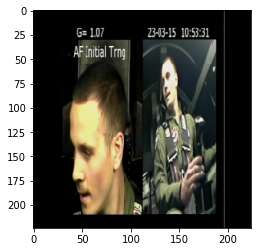

In [40]:
plt.imshow(x[0])

In [19]:
model_data.trn_dl.dataset[0]

(array([[[-2.01343, -2.01343, -2.01343, ..., -2.01343, -2.01343, -2.01343],
         [-2.01343, -2.01343, -2.01343, ..., -2.01343, -2.01343, -2.01343],
         [-2.01343, -2.01343, -2.01343, ..., -2.01343, -2.01343, -2.01343],
         ...,
         [-2.01343, -2.01343, -2.01343, ..., -2.01343, -2.01343, -2.01343],
         [-2.01343, -2.01343, -2.01343, ..., -2.01343, -2.01343, -2.01343],
         [-2.01343, -2.01343, -2.01343, ..., -2.01343, -2.01343, -2.01343]],
 
        [[-1.92891, -1.92891, -1.92891, ..., -1.92891, -1.92891, -1.92891],
         [-1.92891, -1.92891, -1.92891, ..., -1.92891, -1.92891, -1.92891],
         [-1.92891, -1.92891, -1.92891, ..., -1.92891, -1.92891, -1.92891],
         ...,
         [-1.92891, -1.92891, -1.92891, ..., -1.92891, -1.92891, -1.92891],
         [-1.92891, -1.92891, -1.92891, ..., -1.92891, -1.92891, -1.92891],
         [-1.92891, -1.92891, -1.92891, ..., -1.92891, -1.92891, -1.92891]],
 
        [[-1.69812, -1.69812, -1.69812, ..., -1.69812,

Another check that I did things right, by making sure I can pull out a piece of data and view it:

In [20]:
tmep = next(iter(model_data.trn_dl))[0]

In [26]:
x = model_data.val_ds.denorm(to_np(tmep[0]))

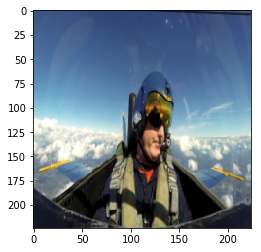

In [31]:
plt.imshow(x[0])

***NOTE***: I wonder if this will be an issue though:

In [34]:
model_data.trn_ds

In [33]:
model_data.val_ds

## 2. Architecture

In [44]:
n_clas = 1 + 1
k = 1

class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf // k)


class OutConv(nn.Module): # 2 separate output conv layers: bbx reg & clsfn
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, n_clas*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k), 
                flatten_conv(self.oconv2(x), self.k)]

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)
    
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn  = ConvLearner(md, models)
learn.opt_fn = optim.Adam

NameError: name 'md' is not defined

In [45]:
learn = ConvLearner.pretrained(f_model, model_data, metrics=[accuracy])
learn.opt_fn = optim.Adam

AttributeError: 'ConcatLblDataset' object has no attribute 'c'

In [ ]:
class ConvBlock

In [ ]:
class SSD_Head(nn.Module):
    ## TODO

## 3. Loss Function

## 4. Training